# 1. Setup

In [1]:
import numpy as np
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
plt.style.use('ggplot')
plt.rcParams['axes.grid'] = False

In [2]:
data_path = Path('./data')
model_path = Path('./models')

model_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Load data
ts1 = pickle.load(open(data_path / 'time_series_1.pickle', 'rb'))
ts2 = pickle.load(open(data_path / 'time_series_2.pickle', 'rb'))
y = pickle.load(open(data_path / 'y.pickle', 'rb'))

In [4]:
# Merge the 2 input time series. This gives us (4000, 5000, 2), which corresponds to
# (n_sequences, n_timesteps, n_features) which is what is needed to train sequence
# models
X = np.stack([ts1, ts2], axis=2)
X.shape

(4000, 5000, 2)

# 2. Exploratory data analysis

## 2.1. Label distribution

In [5]:
np.unique(y, return_counts=True)

(array([0., 1., 2., 3.]), array([1000, 1000, 1000, 1000], dtype=int64))

It appears we have an even distribution of the labels here. Therefore, assuming we care equally about all turbine operating modes, accuracy can be considered a sensible evaluation metric.

## 2.2. Visualising the sensor data for each state

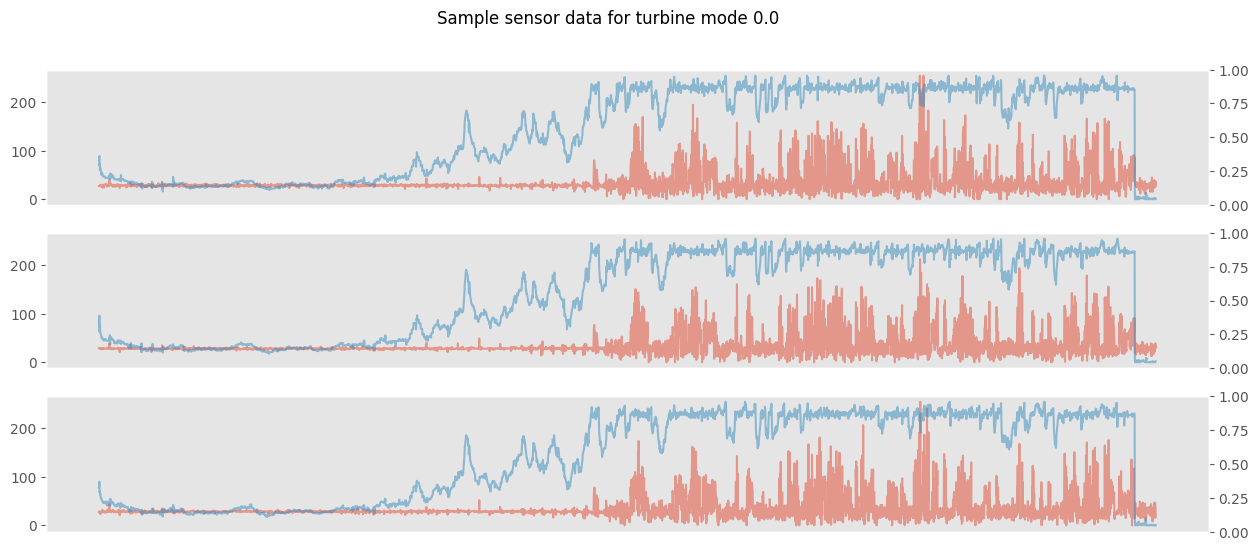

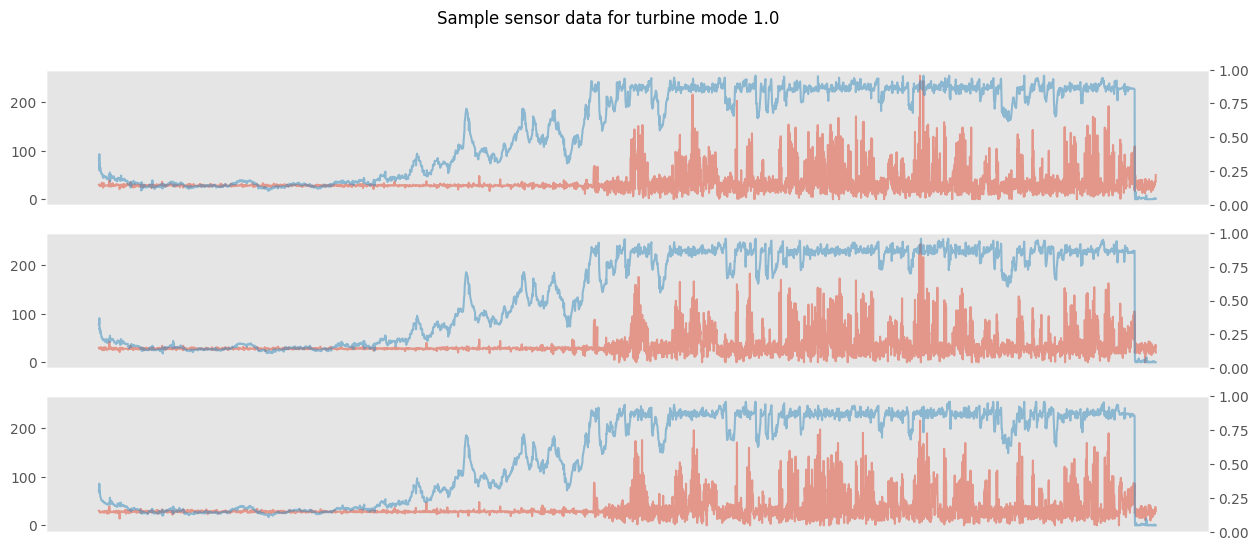

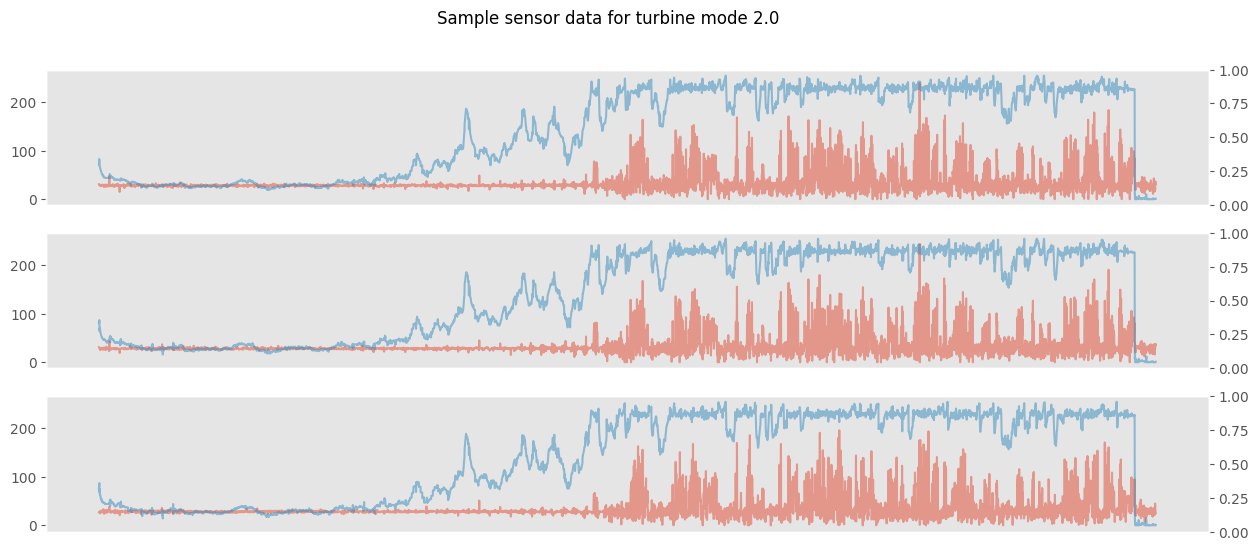

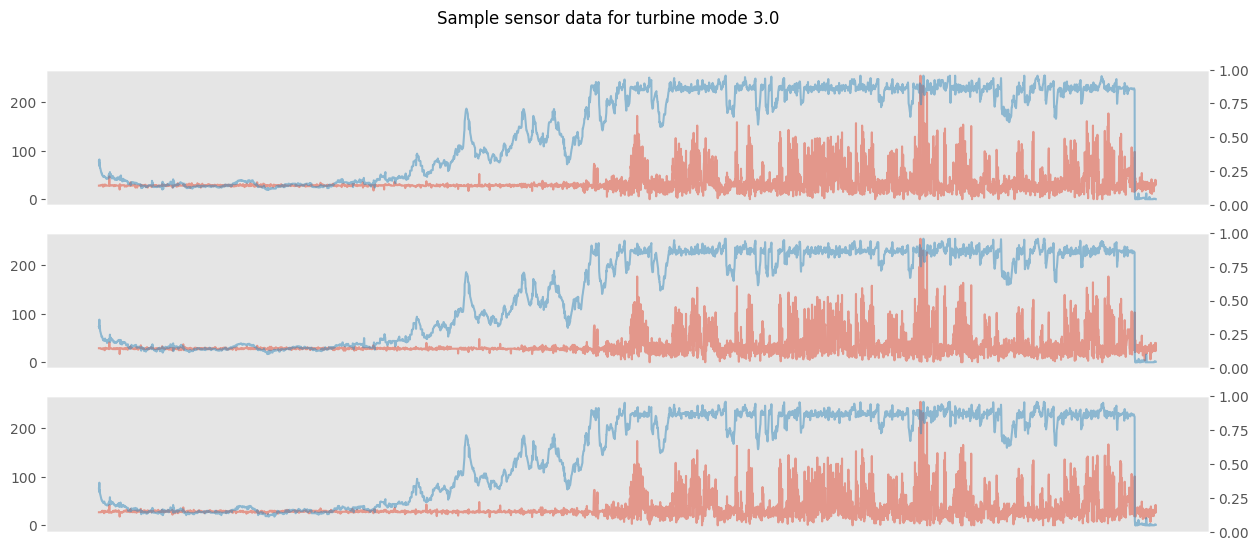

In [6]:
for turbine_mode in set(y):
    # Take the first 3 samples from each turbine mode
    sample_turbine_mode_indices = np.argwhere(y == turbine_mode)[:3].squeeze()

    fig, axs = plt.subplots(3, 1, figsize=(15, 6))
    fig.suptitle(f'Sample sensor data for turbine mode {turbine_mode}')

    for row_num, sample_turbine_mode_index in enumerate(sample_turbine_mode_indices):
        plot_data = X[sample_turbine_mode_index]
        
        ax_to_plot = axs[row_num]

        ax_to_plot.plot(plot_data[:, 0].squeeze(), alpha=0.5)
        ax_to_plot.twinx()
        ax_to_plot.plot(plot_data[:, 1].squeeze(), alpha=0.5)

        ax_to_plot.get_xaxis().set_visible(False)

    plt.show()

I appears that there is no noticeable difference between the sampled sensor data of the 4 modes. We could try and plot the average sensor data of each mode.

In [7]:
def plot_average_sensor_data(X):
    fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    for i, turbine_mode in enumerate(set(y)):
        turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

        axs[i].set_title(f'Average sensor data for turbine mode {turbine_mode}')

        plot_data = X[turbine_mode_indices].mean(axis=0)

        axs[i].plot(plot_data[:, 0].squeeze(), alpha=.5)
        axs[i].twinx()
        axs[i].plot(plot_data[:, 1].squeeze(), alpha=.5)

    plt.show()


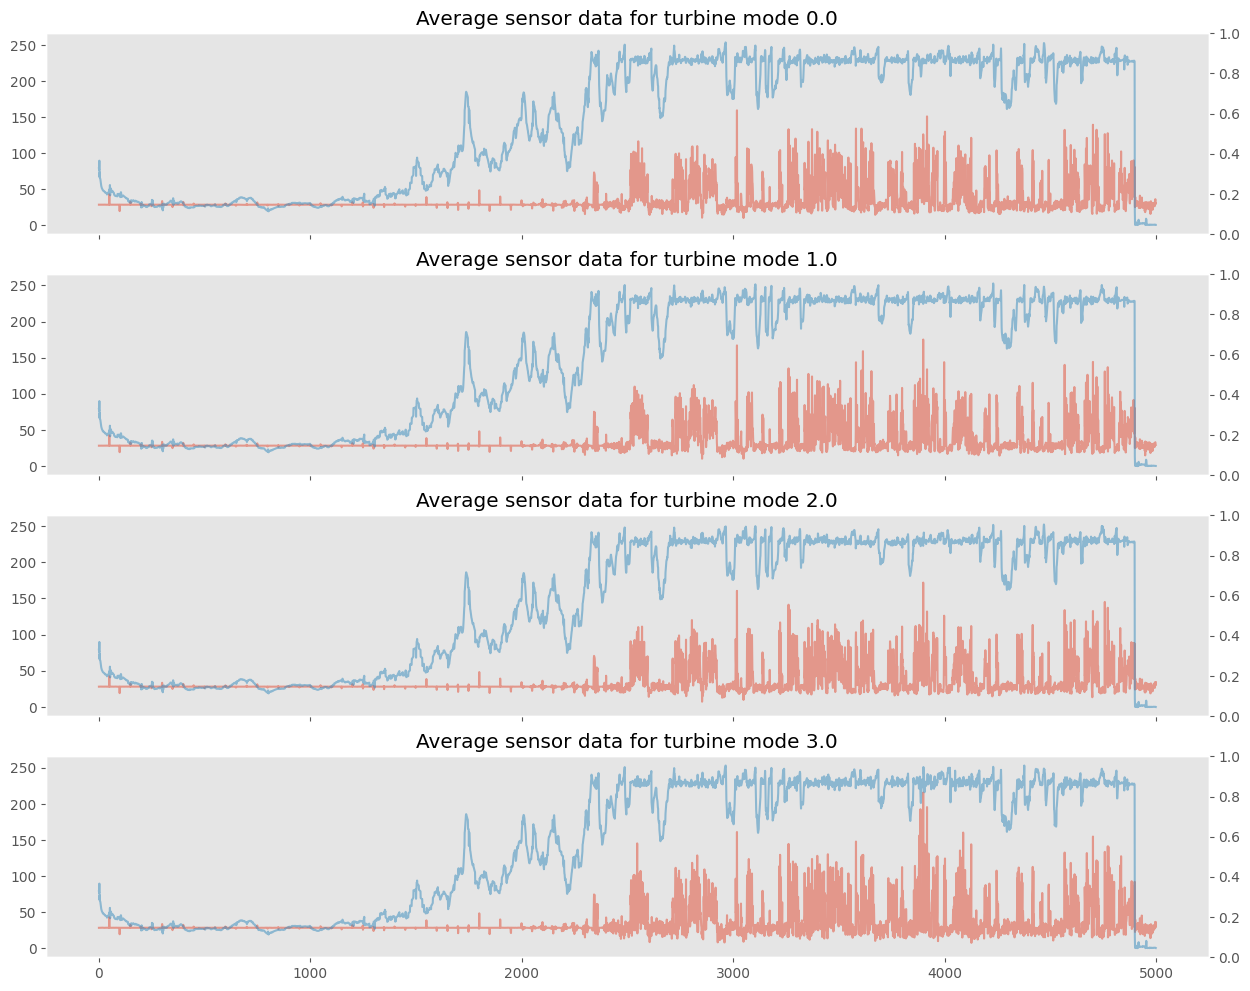

In [8]:
plot_average_sensor_data(X)

However, when we look at the average of each mode, there's something quite noticeable: Around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes. Therefore, the differences between the readings of the 2 sensors may be useful here.

## 2.3. Visualising scaled data

In [9]:
print(stats.describe(np.vstack(X)))

DescribeResult(nobs=20000000, minmax=(array([0, 0], dtype=uint8), array([255, 255], dtype=uint8)), mean=array([ 34.72364305, 143.11656495]), variance=array([ 494.10723608, 7862.09026855]), skewness=array([ 2.99150686, -0.26584355]), kurtosis=array([11.89889674, -1.6850116 ]))


Overall, the reading of sensors appear to have the same lower and upper bounds, from 0 to 255. However, on average, the second sensor have much more variance and value than the first one. We can consider the second sensor to be on a different scale. Therefore, let's try to normalise them to 0 mean and unit variance for ease of analysis. However, when we get to the modelling stage, if we want to apply this technique, the scaling will only be fitted on the training set.

In [10]:
def normalise_data(X, scaler=None):
    # If no scaler is provided, create a scaler, then fit it to the data
    if scaler is None:
        scaler = StandardScaler()
        scaler = scaler.fit(X.reshape(-1, X.shape[2]))

    # Reshape the data to 2D for scaling, then reshape it back to its original shape
    normalise_data = scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
    
    return scaler, normalise_data

In [11]:
scaler, X_normalised = normalise_data(X)

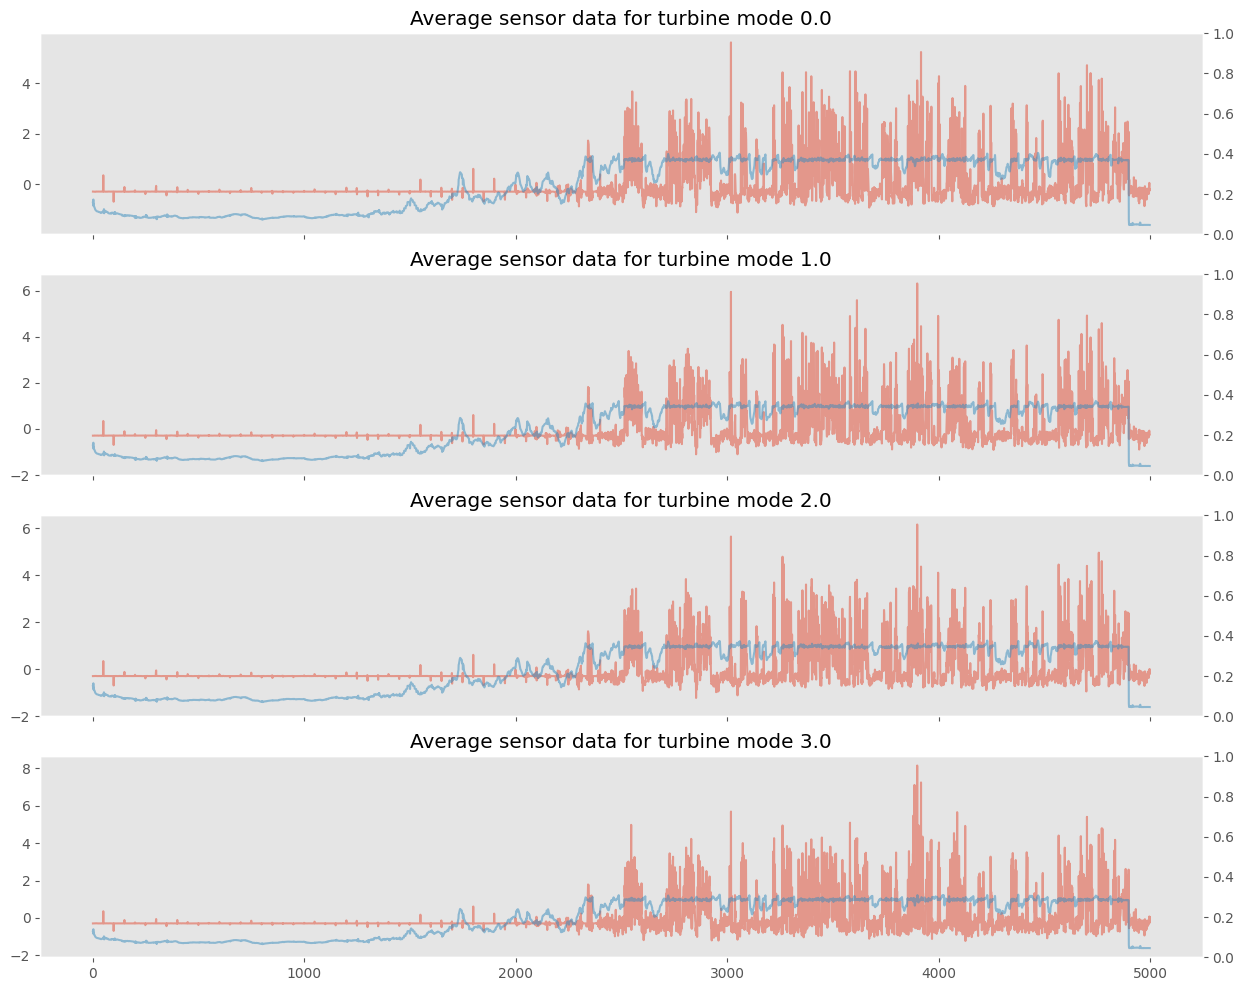

In [12]:
plot_average_sensor_data(X_normalised)

As discussed in the previous section, the difference between the readings from the two sensors may be indicative of the turbine mode (at least for the 4th mode). We will now analyse to see if there is any pattern in the difference.

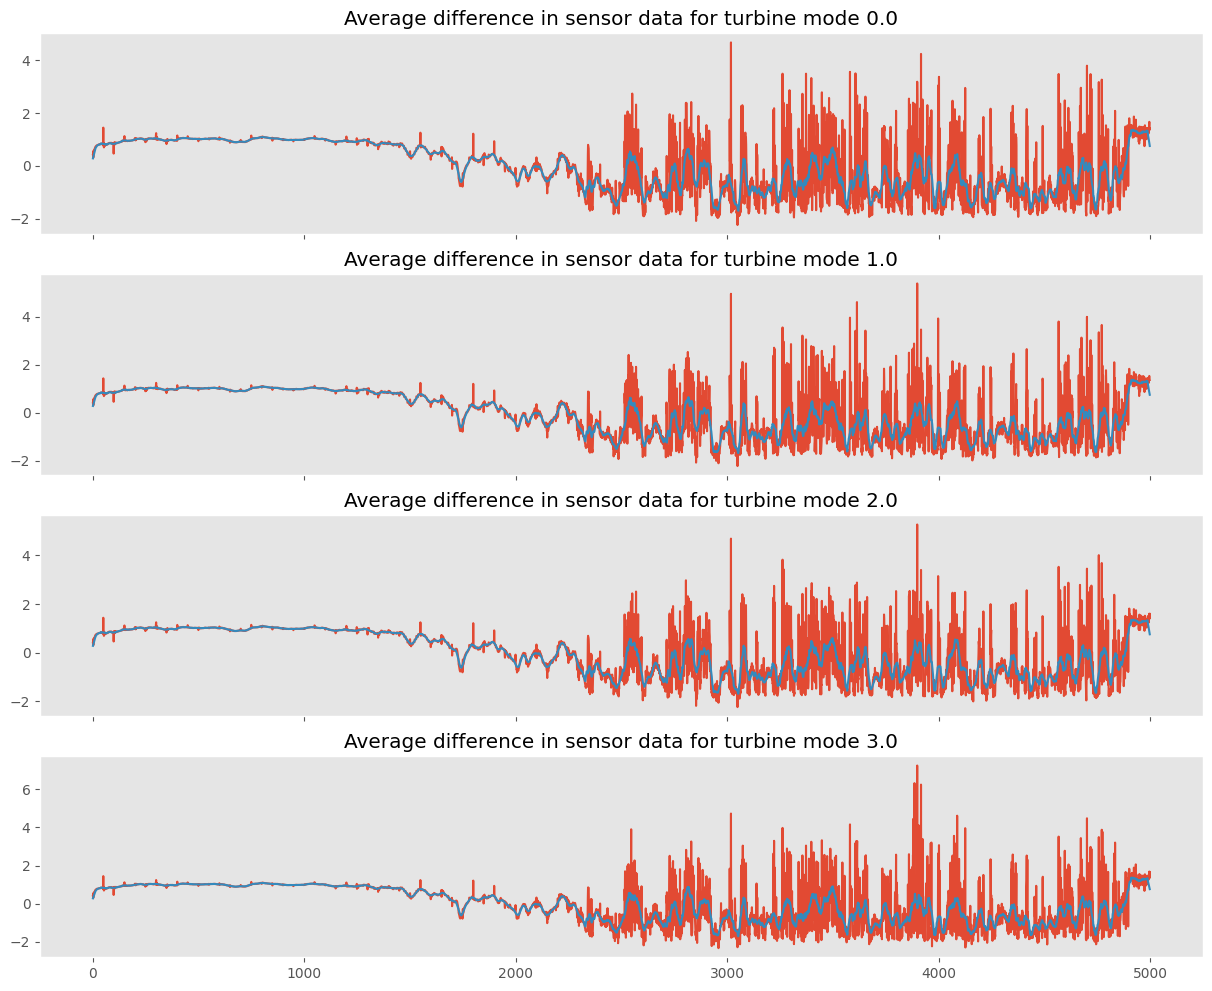

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

for i, turbine_mode in enumerate(set(y)):
    turbine_mode_indices = np.argwhere(y == turbine_mode).squeeze()

    sensor_data = X_normalised[turbine_mode_indices, :, :]
    
    plot_data = (sensor_data[:, :, 0] - sensor_data[:, :, 1]).mean(axis=0)

    axs[i].set_title(f'Average difference in sensor data for turbine mode {turbine_mode}')
    axs[i].plot(plot_data.squeeze())
    axs[i].plot(np.convolve(plot_data.squeeze(), np.ones(24) / 24, mode='same'))

plt.show()


In terms of the summary statistics for the scaled data:

In [14]:
for turbine_mode in set(y):
    turbine_mode_indices = np.argwhere(y == turbine_mode).flatten()

    sensor_data = X_normalised[turbine_mode_indices, :, :]

    # Add rate of change
    sensor_data = np.concatenate(
        [
            sensor_data,
            (sensor_data[:, :, 0] - sensor_data[:, :, 1])[..., np.newaxis],
        ],
        axis=2,
    )

    print(f'Summary statistic for turbine mode {turbine_mode}')
    print(stats.describe(np.vstack(sensor_data)))

Summary statistic for turbine mode 0.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.29065275])), mean=array([-1.36906311e-03, -3.12326507e-05, -1.33783045e-03]), variance=array([1.00356418, 0.99997435, 1.46111824]), skewness=array([ 3.02111839, -0.26575111,  0.34790822]), kurtosis=array([12.2643988 , -1.68523873,  1.39216469]))
Summary statistic for turbine mode 1.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.17787303])), mean=array([-0.00245772,  0.00163809, -0.00409581]), variance=array([1.00053517, 1.00297503, 1.4607519 ]), skewness=array([ 3.02892768, -0.26552219,  0.34254938]), kurtosis=array([12.21447021, -1.68566997,  1.28036494]))
Summary statistic for turbine mode 2.0
DescribeResult(nobs=5000000, minmax=(array([-1.56212106, -1.61406456, -2.82393927]), array([9.90962657, 1.26181821, 9.20042897])), mean=array([ 0.00044677, -0.0018547 

Analysing the scaled data does not provide better insights. In terms of the overall trend and summary statistics, there is no clear difference in sensor data across all 4 modes.

Another the aspect that these plots and statistics failed to capture is very subtle anomalies, as they will be averaged out, and they will not be visible when we look at the time series of 5,000 data points all at once. Therefore, we can propose the following hypotheses:

- Local patterns (e.g., the spikes) may be more important in classifying the turbine modes than global ones (e.g., overall trend, summary statistics).
- Anomalies that are very subtle and very hard to capture visually could be important in classifying the turbine modes.

Amongst the deep learning approaches, convolutional-based neural networks are very good for identifying these patterns and thus can be promising in this task.

# 3. Modelling

**Question 1**: Discuss what type of sequence prediction approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible to predict the operating mode of a turbine based on the two sensor reading time series. Also describe what data shape you need to use for your chosen approach.

**Answer**:

- **sequence-to-vector**: This is a natural choice - We are dealing with a time series classification problems. We have 4000 sequences that matches to 4000 operating modes.
- **sequence-to-sequence**: This is suitable when the output can be a sequence (e.g., time series), or when there is some dependency between the operating modes. However in our case, there is no time information so we won't be able to connect these 4000 operating modes. We can treat them as independent. Also, each sequence has a length of 5000, and we only have one label for the whole sequence, so won't be able to model this as a seq-to-seq problem. Finally, we do not know if the sequences are ordered and hence it would be risky to make such assumption.
- **encoder-decoder**: This works best for translation tasks, or when output is not a scalar, which makes this approach not suitable for our problem.

To follow the sequence-to-vector approach, the data needs to be reshaped as follows:
- input: `(n_batches, batch_size, n_timesteps, n_features)`.
- Output: `(n_batches, batch_size, )`. 

In our case, if the batch size is 64 and the sequences are passed in without further processing, the input shape for each batch would be `(64, 5000, 2)` and the output shape would be `(64, )`

**Question 2**: Create an iterator (ideally, a tensorflow.data.Dataset) that produces batches of data formatted in the appropriate way for your chosen approach.

In [5]:
def scale_data(X):
    # Scale the data from 0-255 to 0-1
    return X / 255.0

In [6]:
# Perform a 80-10-10 train-val-test split
X_train, X_other, y_train, y_other = train_test_split(scale_data(X), y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, stratify=y_other, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(3200, 5000, 2) (400, 5000, 2) (400, 5000, 2)


In [20]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(10)
    .batch(64)
    .prefetch(1)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(64)
    .prefetch(1)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(64)
    .prefetch(1)
)

In [18]:
# Check if the dataset shape is as expected
list(train_dataset.as_numpy_iterator())[0][0].shape

(64, 5000, 2)

In [13]:
def train_model(model, train_dataset, val_dataset, test_dataset, optimizer=None):
    tf.random.set_seed(42)

    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics = ['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(model_path / model.name, save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    ]

    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=2,
    )

    # Plot performance
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['loss'], label="Training")
    axs[0].plot(history.history['val_loss'], label="Validation")
    axs[0].set_title('Loss (categorical cross entropy)')
    axs[1].plot(history.history['accuracy'], label="Training")
    axs[1].plot(history.history['val_accuracy'], label="Validation")
    axs[1].set_title('Accuracy')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # Load the best model
    model = tf.keras.models.load_model(model_path / model.name)

    # Evaluate
    print('Train performance')
    train_loss, train_accuracy = model.evaluate(train_dataset)
    print('Val performance')
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print('Test performance')
    test_loss, test_accuracy = model.evaluate(test_dataset)

    return model, (model.name, train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)


In [25]:
# Initiate an empty list to store all results. We'll later convert this to a pandas
# dataframe to compare the results
all_metrics = []

## 3.1. Baselines

Before investing time in developing a neural network, it is useful to establish some baselines:

- Random prediction: Since we have an even split between all turbines modes, predicting randomly (or predicting only one turbine mode) can gives us 25% accuracy.
- Build a multi-class logistic regression to predict the turbine mode based on the summary statistics: This approach may not be significantly better than random prediction because we have discovered that all 4 modes had similar summary statistics.

Therefore, we can determine our baseline accuracy to be 25%

## 3.2. Main approach

### 3.2.1. Reccurent networks

We can include this method in for the sake of completeness. This is because these networks takes longer to train, and as noted in section 2, local patterns instead of sequential patterns could be indicative of the turbine modes. In addition, since our sequence length is 5000, recurrent models will encounter difficulties learning such sequences. Here, a `GRU` layer was chosen as it is capable of memorising long-term patterns. This is useful comparing to using simple recurrent neural network, because if the point of interest is at the middle of the sequence, then by the time the recurrent network gets to the end, it would have already 'forgotten' the point of interest. Here, we rely on GRU's capability of memorising long-past information until the end of the sequence.

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(128, input_shape=(None, X.shape[2])),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='recurrent_gru'
)
model.summary()

Model: "recurrent_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128)               50688     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 59,204
Trainable params: 59,204
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 21s - loss: 1.3865 - accuracy: 0.2422 - val_loss: 1.3851 - val_accuracy: 0.2575 - 21s/epoch - 416ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3849 - accuracy: 0.2700 - val_loss: 1.3834 - val_accuracy: 0.2850 - 18s/epoch - 366ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3830 - accuracy: 0.2928 - val_loss: 1.3800 - val_accuracy: 0.3250 - 18s/epoch - 366ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3783 - accuracy: 0.2869 - val_loss: 1.3728 - val_accuracy: 0.2675 - 18s/epoch - 358ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3670 - accuracy: 0.3156 - val_loss: 1.3552 - val_accuracy: 0.2925 - 18s/epoch - 361ms/step
Epoch 6/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3471 - accuracy: 0.3203 - val_loss: 1.3282 - val_accuracy: 0.4275 - 18s/epoch - 369ms/step
Epoch 7/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3232 - accuracy: 0.3744 - val_loss: 1.2992 - val_accuracy: 0.4075 - 18s/epoch - 360ms/step
Epoch 8/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.3158 - accuracy: 0.3931 - val_loss: 1.2755 - val_accuracy: 0.4075 - 18s/epoch - 358ms/step
Epoch 9/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.2457 - accuracy: 0.4216 - val_loss: 1.2559 - val_accuracy: 0.3850 - 18s/epoch - 359ms/step
Epoch 10/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.2116 - accuracy: 0.4478 - val_loss: 1.1508 - val_accuracy: 0.5000 - 18s/epoch - 363ms/step
Epoch 11/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.1849 - accuracy: 0.4559 - val_loss: 1.1342 - val_accuracy: 0.5350 - 18s/epoch - 363ms/step
Epoch 12/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 1.0896 - accuracy: 0.4975 - val_loss: 1.0809 - val_accuracy: 0.5500 - 18s/epoch - 360ms/step
Epoch 13/200
50/50 - 15s - loss: 1.0771 - accuracy: 0.5081 - val_loss: 1.0934 - val_accuracy: 0.5225 - 15s/epoch - 294ms/step
Epoch 14/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 1.0454 - accuracy: 0.5122 - val_loss: 1.0649 - val_accuracy: 0.5500 - 19s/epoch - 379ms/step
Epoch 15/200
50/50 - 15s - loss: 1.0178 - accuracy: 0.5322 - val_loss: 1.0817 - val_accuracy: 0.5125 - 15s/epoch - 292ms/step
Epoch 16/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 1.0492 - accuracy: 0.5200 - val_loss: 1.0378 - val_accuracy: 0.5225 - 19s/epoch - 381ms/step
Epoch 17/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.9922 - accuracy: 0.5397 - val_loss: 1.0081 - val_accuracy: 0.5375 - 18s/epoch - 366ms/step
Epoch 18/200
50/50 - 14s - loss: 0.9803 - accuracy: 0.5500 - val_loss: 1.0191 - val_accuracy: 0.5450 - 14s/epoch - 285ms/step
Epoch 19/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 20s - loss: 1.0061 - accuracy: 0.5469 - val_loss: 0.9486 - val_accuracy: 0.5700 - 20s/epoch - 396ms/step
Epoch 20/200
50/50 - 15s - loss: 1.0475 - accuracy: 0.5344 - val_loss: 1.1548 - val_accuracy: 0.4975 - 15s/epoch - 293ms/step
Epoch 21/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 20s - loss: 0.9698 - accuracy: 0.5587 - val_loss: 0.9031 - val_accuracy: 0.5925 - 20s/epoch - 397ms/step
Epoch 22/200
50/50 - 14s - loss: 0.9419 - accuracy: 0.5678 - val_loss: 0.9545 - val_accuracy: 0.5700 - 14s/epoch - 284ms/step
Epoch 23/200
50/50 - 14s - loss: 0.9643 - accuracy: 0.5700 - val_loss: 0.9366 - val_accuracy: 0.5825 - 14s/epoch - 287ms/step
Epoch 24/200
50/50 - 14s - loss: 0.9297 - accuracy: 0.5803 - val_loss: 0.9612 - val_accuracy: 0.5825 - 14s/epoch - 288ms/step
Epoch 25/200
50/50 - 14s - loss: 0.9223 - accuracy: 0.5825 - val_loss: 0.9324 - val_accuracy: 0.5925 - 14s/epoch - 281ms/step
Epoch 26/200
50/50 - 14s - loss: 0.9198 - accuracy: 0.5913 - val_loss: 1.2871 - val_accuracy: 0.4675 - 14s/epoch - 286ms/step
Epoch 27/200
50/50 - 15s - loss: 0.9299 - accuracy: 0.5950 - val_loss: 0.9264 - val_accuracy: 0.6025 - 15s/epoch - 304ms/step
Epoch 28/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.8577 - accuracy: 0.6191 - val_loss: 0.8771 - val_accuracy: 0.6250 - 19s/epoch - 386ms/step
Epoch 29/200
50/50 - 14s - loss: 0.8893 - accuracy: 0.5987 - val_loss: 1.0153 - val_accuracy: 0.5400 - 14s/epoch - 283ms/step
Epoch 30/200
50/50 - 14s - loss: 0.8844 - accuracy: 0.6100 - val_loss: 1.0883 - val_accuracy: 0.5150 - 14s/epoch - 289ms/step
Epoch 31/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.9123 - accuracy: 0.5966 - val_loss: 0.8468 - val_accuracy: 0.6525 - 18s/epoch - 367ms/step
Epoch 32/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.8058 - accuracy: 0.6506 - val_loss: 0.7904 - val_accuracy: 0.6500 - 18s/epoch - 359ms/step
Epoch 33/200
50/50 - 14s - loss: 0.8370 - accuracy: 0.6347 - val_loss: 0.9656 - val_accuracy: 0.5725 - 14s/epoch - 284ms/step
Epoch 34/200
50/50 - 14s - loss: 0.8663 - accuracy: 0.6250 - val_loss: 1.0204 - val_accuracy: 0.5325 - 14s/epoch - 287ms/step
Epoch 35/200
50/50 - 14s - loss: 0.8618 - accuracy: 0.6272 - val_loss: 0.8530 - val_accuracy: 0.6150 - 14s/epoch - 288ms/step
Epoch 36/200
50/50 - 14s - loss: 0.8366 - accuracy: 0.6338 - val_loss: 0.8148 - val_accuracy: 0.6575 - 14s/epoch - 280ms/step
Epoch 37/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.8103 - accuracy: 0.6441 - val_loss: 0.7155 - val_accuracy: 0.6950 - 19s/epoch - 382ms/step
Epoch 38/200
50/50 - 14s - loss: 0.8773 - accuracy: 0.6075 - val_loss: 0.7598 - val_accuracy: 0.6750 - 14s/epoch - 287ms/step
Epoch 39/200
50/50 - 14s - loss: 0.7807 - accuracy: 0.6684 - val_loss: 0.7565 - val_accuracy: 0.6925 - 14s/epoch - 281ms/step
Epoch 40/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.7837 - accuracy: 0.6669 - val_loss: 0.6780 - val_accuracy: 0.7425 - 18s/epoch - 359ms/step
Epoch 41/200
50/50 - 14s - loss: 0.8013 - accuracy: 0.6600 - val_loss: 0.7575 - val_accuracy: 0.6875 - 14s/epoch - 287ms/step
Epoch 42/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.7501 - accuracy: 0.6787 - val_loss: 0.6277 - val_accuracy: 0.7400 - 19s/epoch - 389ms/step
Epoch 43/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.7847 - accuracy: 0.6697 - val_loss: 0.6274 - val_accuracy: 0.7475 - 19s/epoch - 372ms/step
Epoch 44/200
50/50 - 14s - loss: 0.6629 - accuracy: 0.7212 - val_loss: 0.6862 - val_accuracy: 0.7000 - 14s/epoch - 289ms/step
Epoch 45/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.6897 - accuracy: 0.6991 - val_loss: 0.5978 - val_accuracy: 0.7700 - 18s/epoch - 368ms/step
Epoch 46/200
50/50 - 14s - loss: 0.6098 - accuracy: 0.7406 - val_loss: 0.6033 - val_accuracy: 0.7525 - 14s/epoch - 282ms/step
Epoch 47/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.6113 - accuracy: 0.7397 - val_loss: 0.5298 - val_accuracy: 0.7850 - 19s/epoch - 381ms/step
Epoch 48/200
50/50 - 15s - loss: 0.7203 - accuracy: 0.6956 - val_loss: 0.5781 - val_accuracy: 0.7650 - 15s/epoch - 296ms/step
Epoch 49/200
50/50 - 15s - loss: 0.6409 - accuracy: 0.7337 - val_loss: 0.6818 - val_accuracy: 0.7050 - 15s/epoch - 291ms/step
Epoch 50/200
50/50 - 14s - loss: 0.7204 - accuracy: 0.6906 - val_loss: 0.5643 - val_accuracy: 0.7775 - 14s/epoch - 284ms/step
Epoch 51/200
50/50 - 15s - loss: 0.6132 - accuracy: 0.7409 - val_loss: 0.6428 - val_accuracy: 0.7350 - 15s/epoch - 293ms/step
Epoch 52/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.5665 - accuracy: 0.7638 - val_loss: 0.5055 - val_accuracy: 0.7825 - 18s/epoch - 364ms/step
Epoch 53/200
50/50 - 14s - loss: 0.5734 - accuracy: 0.7569 - val_loss: 0.5135 - val_accuracy: 0.7950 - 14s/epoch - 282ms/step
Epoch 54/200
50/50 - 14s - loss: 0.6020 - accuracy: 0.7472 - val_loss: 0.5108 - val_accuracy: 0.8025 - 14s/epoch - 286ms/step
Epoch 55/200
50/50 - 15s - loss: 0.6134 - accuracy: 0.7372 - val_loss: 0.5118 - val_accuracy: 0.7775 - 15s/epoch - 302ms/step
Epoch 56/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.5554 - accuracy: 0.7713 - val_loss: 0.4825 - val_accuracy: 0.7875 - 19s/epoch - 375ms/step
Epoch 57/200
50/50 - 14s - loss: 0.5651 - accuracy: 0.7566 - val_loss: 0.5225 - val_accuracy: 0.7550 - 14s/epoch - 285ms/step
Epoch 58/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.5446 - accuracy: 0.7703 - val_loss: 0.4714 - val_accuracy: 0.7975 - 18s/epoch - 367ms/step
Epoch 59/200
50/50 - 14s - loss: 0.6526 - accuracy: 0.7272 - val_loss: 0.5268 - val_accuracy: 0.7875 - 14s/epoch - 287ms/step
Epoch 60/200
50/50 - 14s - loss: 0.5853 - accuracy: 0.7484 - val_loss: 0.6879 - val_accuracy: 0.7100 - 14s/epoch - 282ms/step
Epoch 61/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.5884 - accuracy: 0.7550 - val_loss: 0.4564 - val_accuracy: 0.8200 - 19s/epoch - 380ms/step
Epoch 62/200
50/50 - 15s - loss: 0.5377 - accuracy: 0.7788 - val_loss: 0.5213 - val_accuracy: 0.7700 - 15s/epoch - 290ms/step
Epoch 63/200
50/50 - 15s - loss: 0.5298 - accuracy: 0.7769 - val_loss: 0.5260 - val_accuracy: 0.7725 - 15s/epoch - 304ms/step
Epoch 64/200
50/50 - 14s - loss: 0.5651 - accuracy: 0.7622 - val_loss: 0.5264 - val_accuracy: 0.7650 - 14s/epoch - 289ms/step
Epoch 65/200
50/50 - 15s - loss: 0.5045 - accuracy: 0.7859 - val_loss: 0.4770 - val_accuracy: 0.7900 - 15s/epoch - 293ms/step
Epoch 66/200
50/50 - 15s - loss: 0.5170 - accuracy: 0.7812 - val_loss: 0.4587 - val_accuracy: 0.8075 - 15s/epoch - 290ms/step
Epoch 67/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.4902 - accuracy: 0.7928 - val_loss: 0.4268 - val_accuracy: 0.8300 - 19s/epoch - 376ms/step
Epoch 68/200
50/50 - 15s - loss: 0.5840 - accuracy: 0.7469 - val_loss: 0.4314 - val_accuracy: 0.8200 - 15s/epoch - 291ms/step
Epoch 69/200
50/50 - 14s - loss: 0.4865 - accuracy: 0.7991 - val_loss: 0.4362 - val_accuracy: 0.8150 - 14s/epoch - 290ms/step
Epoch 70/200
50/50 - 15s - loss: 0.4670 - accuracy: 0.8059 - val_loss: 0.4434 - val_accuracy: 0.8100 - 15s/epoch - 291ms/step
Epoch 71/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 20s - loss: 0.4703 - accuracy: 0.8016 - val_loss: 0.4177 - val_accuracy: 0.8175 - 20s/epoch - 392ms/step
Epoch 72/200
50/50 - 14s - loss: 0.5072 - accuracy: 0.7859 - val_loss: 0.5934 - val_accuracy: 0.7600 - 14s/epoch - 288ms/step
Epoch 73/200
50/50 - 15s - loss: 0.5062 - accuracy: 0.7906 - val_loss: 0.4247 - val_accuracy: 0.8200 - 15s/epoch - 296ms/step
Epoch 74/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 19s - loss: 0.4696 - accuracy: 0.8047 - val_loss: 0.3891 - val_accuracy: 0.8300 - 19s/epoch - 379ms/step
Epoch 75/200
50/50 - 15s - loss: 0.5558 - accuracy: 0.7697 - val_loss: 0.4765 - val_accuracy: 0.8025 - 15s/epoch - 292ms/step
Epoch 76/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.4526 - accuracy: 0.8169 - val_loss: 0.3813 - val_accuracy: 0.8400 - 18s/epoch - 370ms/step
Epoch 77/200
50/50 - 14s - loss: 0.4591 - accuracy: 0.8097 - val_loss: 0.4938 - val_accuracy: 0.8050 - 14s/epoch - 288ms/step
Epoch 78/200
50/50 - 14s - loss: 0.4473 - accuracy: 0.8159 - val_loss: 0.4330 - val_accuracy: 0.8125 - 14s/epoch - 280ms/step
Epoch 79/200
50/50 - 15s - loss: 0.4410 - accuracy: 0.8147 - val_loss: 0.4276 - val_accuracy: 0.8175 - 15s/epoch - 290ms/step
Epoch 80/200
50/50 - 14s - loss: 0.4321 - accuracy: 0.8206 - val_loss: 0.4535 - val_accuracy: 0.7975 - 14s/epoch - 287ms/step
Epoch 81/200
50/50 - 14s - loss: 0.4192 - accuracy: 0.8306 - val_loss: 0.4131 - val_accuracy: 0.8225 - 14s/epoch - 283ms/step
Epoch 82/200
50/50 - 14s - loss: 0.4735 - accuracy: 0.8003 - val_loss: 0.3821 - val_accuracy: 0.8500 - 14s/epoch - 286ms/step
Epoch 83/200
50/50 - 14s - loss: 0.4333 - accuracy: 0.8238 - val_loss: 1.0319 - val_accuracy: 0.5450 - 14s/epoch - 287ms/step
Epoch

INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 18s - loss: 0.4053 - accuracy: 0.8441 - val_loss: 0.3562 - val_accuracy: 0.8725 - 18s/epoch - 358ms/step
Epoch 86/200
50/50 - 15s - loss: 0.5486 - accuracy: 0.7716 - val_loss: 0.4309 - val_accuracy: 0.8175 - 15s/epoch - 294ms/step
Epoch 87/200
50/50 - 15s - loss: 0.4269 - accuracy: 0.8272 - val_loss: 0.4295 - val_accuracy: 0.8425 - 15s/epoch - 297ms/step
Epoch 88/200
50/50 - 15s - loss: 0.4377 - accuracy: 0.8178 - val_loss: 0.6864 - val_accuracy: 0.6950 - 15s/epoch - 293ms/step
Epoch 89/200


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


INFO:tensorflow:Assets written to: models\recurrent_gru\assets


50/50 - 20s - loss: 0.3853 - accuracy: 0.8487 - val_loss: 0.3194 - val_accuracy: 0.8775 - 20s/epoch - 407ms/step
Epoch 90/200
50/50 - 15s - loss: 0.5481 - accuracy: 0.7688 - val_loss: 0.4114 - val_accuracy: 0.8275 - 15s/epoch - 296ms/step
Epoch 91/200
50/50 - 15s - loss: 0.4400 - accuracy: 0.8184 - val_loss: 0.3502 - val_accuracy: 0.8775 - 15s/epoch - 299ms/step
Epoch 92/200
50/50 - 15s - loss: 0.4228 - accuracy: 0.8278 - val_loss: 0.3469 - val_accuracy: 0.8525 - 15s/epoch - 292ms/step
Epoch 93/200
50/50 - 15s - loss: 0.3646 - accuracy: 0.8531 - val_loss: 0.3742 - val_accuracy: 0.8550 - 15s/epoch - 299ms/step
Epoch 94/200
50/50 - 15s - loss: 0.3850 - accuracy: 0.8444 - val_loss: 0.5717 - val_accuracy: 0.7800 - 15s/epoch - 298ms/step
Epoch 95/200
50/50 - 15s - loss: 0.5823 - accuracy: 0.7616 - val_loss: 0.3414 - val_accuracy: 0.8625 - 15s/epoch - 294ms/step
Epoch 96/200
50/50 - 15s - loss: 0.4646 - accuracy: 0.8025 - val_loss: 0.3365 - val_accuracy: 0.8625 - 15s/epoch - 303ms/step
Epoch

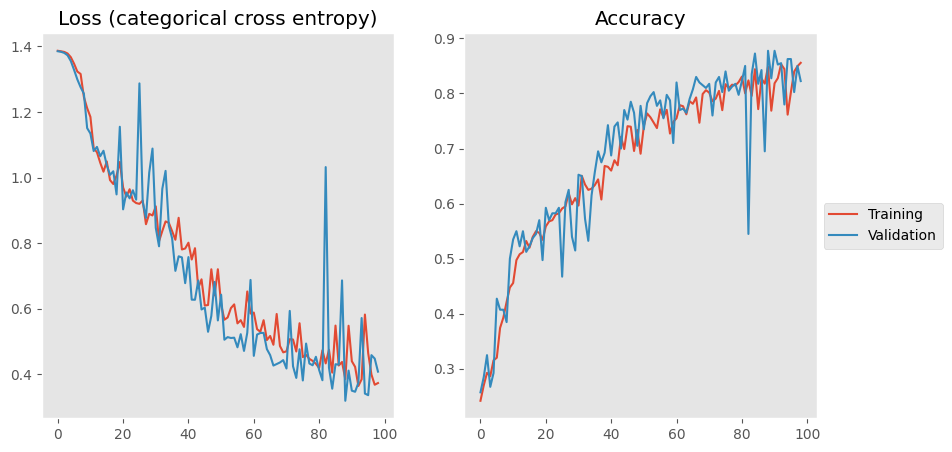

Train performance
50/50 [==============================] - 6s 119ms/step - loss: 0.3196 - accuracy: 0.8697
Val performance
7/7 [==============================] - 1s 112ms/step - loss: 0.3194 - accuracy: 0.8775
Test performance
7/7 [==============================] - 1s 112ms/step - loss: 0.3424 - accuracy: 0.8500


In [ ]:
# Gradient clipping to avoid exploding gradient which is common for long sequences
model, metrics = train_model(
    model,
    train_dataset, val_dataset, test_dataset,
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, clipnorm=1.0)
)
all_metrics.append(metrics)

The model takes a really long time to train, because the training cannot be parallelised and we are dealing with very long sequences. However, it still manages to achieve a very high test accuracy of 85%, which has well surpassed our baseline of 25%.

### 3.2.2. Conv1D-based network

**Question 3**: Create a neural network in TensorFlow to predict the operating mode of a wind turbine based on the sensor data. Make sure that you try out different layers and elements discussed in class, such as Dense, SimpleRNN, GRU, and Conv1D.

**Answer:**

As a starting point, we create a simple neural network with a Conv1D layer as hidden layer. We do have the option of using a `GlobalAveragePooling1D` layer after the convolutional layer instead of a `Flatten` layer, but since we only have 64 filters of Conv1D of size 6, the number of parameters is still quite small, so averaging may result in too much information loss and is not totally necessary.

In [30]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='conv1d_base'
)
model.summary()

Model: "conv1d_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4995, 64)          832       
                                                                 
 flatten (Flatten)           (None, 319680)            0         
                                                                 
 dense_8 (Dense)             (None, 4)                 1278724   
                                                                 
Total params: 1,279,556
Trainable params: 1,279,556
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 15s - loss: 2.9870 - accuracy: 0.4462 - val_loss: 0.7605 - val_accuracy: 0.8075 - 15s/epoch - 293ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.4648 - accuracy: 0.8737 - val_loss: 0.3193 - val_accuracy: 0.9050 - 3s/epoch - 58ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2806 - accuracy: 0.8956 - val_loss: 0.2664 - val_accuracy: 0.9050 - 3s/epoch - 59ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2462 - accuracy: 0.8953 - val_loss: 0.2480 - val_accuracy: 0.9050 - 3s/epoch - 57ms/step
Epoch 5/200
50/50 - 2s - loss: 0.2345 - accuracy: 0.8984 - val_loss: 0.2509 - val_accuracy: 0.9050 - 2s/epoch - 36ms/step
Epoch 6/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2316 - accuracy: 0.8981 - val_loss: 0.2421 - val_accuracy: 0.9050 - 3s/epoch - 58ms/step
Epoch 7/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2277 - accuracy: 0.9022 - val_loss: 0.2399 - val_accuracy: 0.9050 - 3s/epoch - 58ms/step
Epoch 8/200
50/50 - 2s - loss: 0.2223 - accuracy: 0.9047 - val_loss: 0.2418 - val_accuracy: 0.9050 - 2s/epoch - 36ms/step
Epoch 9/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2156 - accuracy: 0.9062 - val_loss: 0.2377 - val_accuracy: 0.9050 - 3s/epoch - 59ms/step
Epoch 10/200
50/50 - 2s - loss: 0.2134 - accuracy: 0.9066 - val_loss: 0.2389 - val_accuracy: 0.9050 - 2s/epoch - 36ms/step
Epoch 11/200
50/50 - 2s - loss: 0.2082 - accuracy: 0.9075 - val_loss: 0.2400 - val_accuracy: 0.9050 - 2s/epoch - 36ms/step
Epoch 12/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 4s - loss: 0.2105 - accuracy: 0.9097 - val_loss: 0.2319 - val_accuracy: 0.9050 - 4s/epoch - 84ms/step
Epoch 13/200


INFO:tensorflow:Assets written to: models\conv1d_base\assets


INFO:tensorflow:Assets written to: models\conv1d_base\assets


50/50 - 3s - loss: 0.2063 - accuracy: 0.9050 - val_loss: 0.2311 - val_accuracy: 0.9050 - 3s/epoch - 56ms/step
Epoch 14/200
50/50 - 2s - loss: 0.2019 - accuracy: 0.9112 - val_loss: 0.2393 - val_accuracy: 0.9025 - 2s/epoch - 36ms/step
Epoch 15/200
50/50 - 2s - loss: 0.1991 - accuracy: 0.9100 - val_loss: 0.2385 - val_accuracy: 0.9050 - 2s/epoch - 36ms/step
Epoch 16/200
50/50 - 2s - loss: 0.1931 - accuracy: 0.9141 - val_loss: 0.2398 - val_accuracy: 0.9025 - 2s/epoch - 35ms/step
Epoch 17/200
50/50 - 2s - loss: 0.1915 - accuracy: 0.9175 - val_loss: 0.2421 - val_accuracy: 0.9025 - 2s/epoch - 36ms/step
Epoch 18/200
50/50 - 2s - loss: 0.1921 - accuracy: 0.9156 - val_loss: 0.2411 - val_accuracy: 0.9075 - 2s/epoch - 36ms/step
Epoch 19/200
50/50 - 2s - loss: 0.1858 - accuracy: 0.9131 - val_loss: 0.2450 - val_accuracy: 0.9075 - 2s/epoch - 36ms/step
Epoch 20/200
50/50 - 2s - loss: 0.1796 - accuracy: 0.9222 - val_loss: 0.2407 - val_accuracy: 0.9000 - 2s/epoch - 35ms/step
Epoch 21/200
50/50 - 2s - los

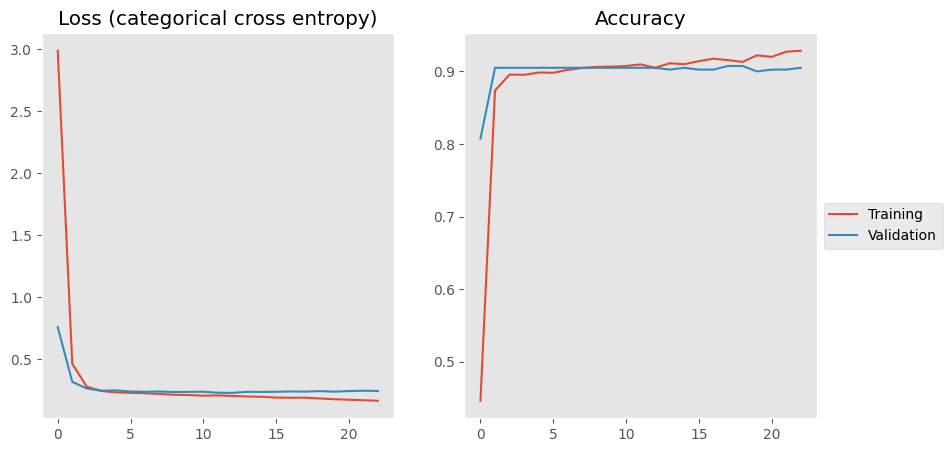

Train performance
50/50 [==============================] - 1s 19ms/step - loss: 0.1973 - accuracy: 0.9022
Val performance
7/7 [==============================] - 0s 18ms/step - loss: 0.2311 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 18ms/step - loss: 0.2567 - accuracy: 0.8900


In [31]:
model, metrics = train_model(model, train_dataset, val_dataset, test_dataset)
all_metrics.append(metrics)

The model started overfitting after the 10th epochs. Interestingly, after only 2 to 3 epochs, the training accuracy was still increasing but validation accuracy has stopped improving. This is understandable as this is a relatively simple model with no regularisation implemented. However, it has managed to achieved better loss and accuracy than the GRU-based model with significantly less time and compute resource.

Next, we can try adding more layers and introducing regularisation to the model.

In [32]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, padding='same'),
        tf.keras.layers.Conv1D(64, 6, padding='same'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv1D(32, 6, padding='same'),
        tf.keras.layers.MaxPool1D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv1d_regularised'
)
model.summary()

Model: "conv1d_regularised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5000, 64)          832       
                                                                 
 conv1d_2 (Conv1D)           (None, 5000, 64)          24640     
                                                                 
 dropout (Dropout)           (None, 5000, 64)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 5000, 32)          12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4998, 32)         0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 159936)            0         
                                                

Epoch 1/200


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


50/50 - 11s - loss: 1.8124 - accuracy: 0.3634 - val_loss: 1.0635 - val_accuracy: 0.4225 - 11s/epoch - 214ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


50/50 - 9s - loss: 0.6084 - accuracy: 0.8303 - val_loss: 0.3313 - val_accuracy: 0.9050 - 9s/epoch - 172ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


50/50 - 9s - loss: 0.2693 - accuracy: 0.8988 - val_loss: 0.2603 - val_accuracy: 0.9050 - 9s/epoch - 171ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


50/50 - 9s - loss: 0.2396 - accuracy: 0.8919 - val_loss: 0.2496 - val_accuracy: 0.9050 - 9s/epoch - 173ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


INFO:tensorflow:Assets written to: models\conv1d_regularised\assets


50/50 - 10s - loss: 0.2340 - accuracy: 0.8934 - val_loss: 0.2479 - val_accuracy: 0.9000 - 10s/epoch - 198ms/step
Epoch 6/200
50/50 - 7s - loss: 0.2288 - accuracy: 0.8919 - val_loss: 0.2493 - val_accuracy: 0.9000 - 7s/epoch - 147ms/step
Epoch 7/200
50/50 - 7s - loss: 0.2232 - accuracy: 0.8975 - val_loss: 0.2547 - val_accuracy: 0.9050 - 7s/epoch - 147ms/step
Epoch 8/200
50/50 - 7s - loss: 0.2248 - accuracy: 0.8963 - val_loss: 0.2504 - val_accuracy: 0.9050 - 7s/epoch - 145ms/step
Epoch 9/200
50/50 - 7s - loss: 0.2198 - accuracy: 0.8963 - val_loss: 0.2639 - val_accuracy: 0.9050 - 7s/epoch - 146ms/step
Epoch 10/200
50/50 - 7s - loss: 0.2176 - accuracy: 0.9006 - val_loss: 0.2956 - val_accuracy: 0.9025 - 7s/epoch - 146ms/step
Epoch 11/200
50/50 - 7s - loss: 0.2187 - accuracy: 0.8959 - val_loss: 0.2793 - val_accuracy: 0.9050 - 7s/epoch - 146ms/step
Epoch 12/200
50/50 - 7s - loss: 0.2137 - accuracy: 0.8997 - val_loss: 0.2645 - val_accuracy: 0.9025 - 7s/epoch - 146ms/step
Epoch 13/200
50/50 - 7s

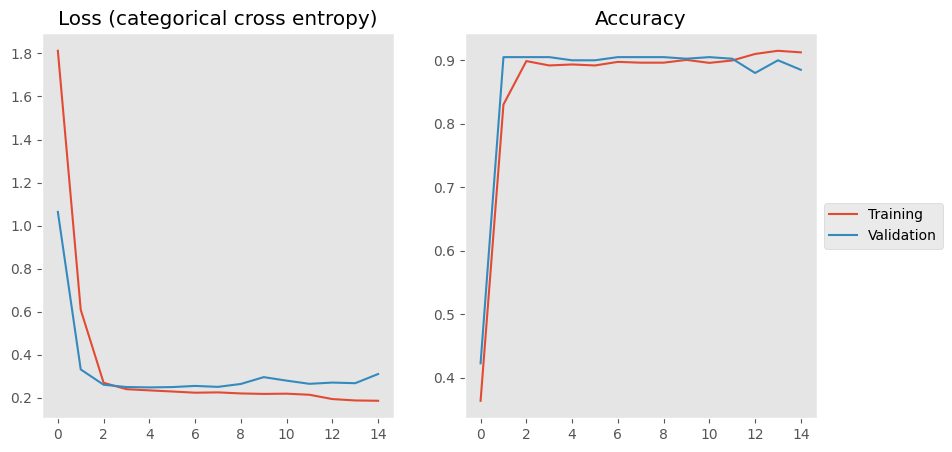

Train performance
50/50 [==============================] - 3s 50ms/step - loss: 0.2210 - accuracy: 0.9041
Val performance
7/7 [==============================] - 0s 44ms/step - loss: 0.2479 - accuracy: 0.9000
Test performance
7/7 [==============================] - 0s 45ms/step - loss: 0.3003 - accuracy: 0.8825


In [33]:
model, metrics = train_model(model, train_dataset, val_dataset, test_dataset)
all_metrics.append(metrics)

It appears that our 'base' model is a really hard baseline to beat! Adding more layers and regularisation did not improve the model.

**Question 4a:** We have come across Conv1D layers as a tool for analyzing time series. Different from recurrent layers such as SimpleRNN, LSTM, or GRU, when we apply a Conv1D layer to a part of a sequence, the operation does not depend on the application of the layer to previous parts of the sequence.

Discuss in which types of (business) applications Conv1D layers can be particularly useful, and in which you should prefer a recurrent layer. 

**Answer:** Convolutional layers in general are useful for problems where a sub-section of the data can be informative, regardless of its position. Therefore, Conv1D layers are useful in applications such as anomaly detection for time series, or time series classification (like this task) where each class can be determined by a local pattern, for example, sudden spikes in sensor readings can be attributed to faulty equipments. In contrast, recurrent layers are more suited for applications where the long-term, sequential dependency in data is important, for example, time series prediction, speech recognition. In our case, this could be relevant if the task is to predict the next `n` sensor readings, because the next sensor readings can heavily depends on the recent readings.

In addition, since convolutional layers can be trained in parallel, they are more suitable for applications involving a large volume of data, or long sequences, or with limited computing power, than recurrent layers, which need to be trained sequentially. As a result, training convolutional models would take significantly less time.

Therefore, in this project, it would be extremely unlikely for reccurent models to outperform our models using convolutional layers.

### 3.2.3. Conv2D

**Question 5:** Another, less frequently used tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 which depict the process of converting one or multiple time series into “images” used within a CNN.

In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs


**Answer:** Based on the insights in section 2 - Exploratory data analysis, there is very little to no difference in the overall trends of 4 turbine modes. Therefore, sequential models such as would not perform well. In contrast, convolutional layers can work really well in our problem because local pattern may provide strong signals for identifying the turbine modes (e.g., in section 2, around the 3,800th timesteps, the red line spikes up and reaches the blue line for turbine mode 3. This pattern does not appear in the remaining turbine modes.)

In the paper, the novelty is in the way the timeseries data are transformed into images - that is by dividing the time series (1 dimensional) into sequences of equal length and stack them vertically to construct a 2-dimensional array. This method may work really well for our problem, because there may be a cyclical pattern in the data. This is because the movement of the wind turbine blades are repetitive, which can produce cyclical data. Therefore, if the length of the sub-sequence are chosen carefully, the correlation between two adjacent elements in the 2D array could be very high for turbines operating in normal conditions.

For example, assuming we have a sensor that records the angle of a turbine blade in regular intervals, then the data it produces may be `120-240-360-120-240-360-120-240-360`. If the turbine functions normally, then we can expect the sub-sequence of `120-240-360` to repeat indefinitely. However, the angles of a mal-functioning turbine blade may be `120-242-360-120-241-360-120-239-360`. This difference is very subtle and would be impossible to notice visually. But if we follow the paper's approach by diving the data into sequences of length 3 and stacking them vertically, we will have the following:

- Healthy turbine:
```
| 120 | 240 | 360 |
| 120 | 240 | 360 |
| 120 | 240 | 360 |
```

- Mal-functioning turbine:
```
| 120 | 242 | 360 |
| 120 | 241 | 360 |
| 120 | 239 | 360 |
```

A 2D convolutional layer will be able to pick up the difference in the turbine blade's angles in the second column of the mal-functioning turbine's data.

For this to work, the sequence length will need to be tuned so that the correlation between two adjacent pixels are maximised. In cases where the length of the original time series is not divisble by the sequence length, it would be required to pad the last sequence to produce a rectangular image. However, in this paper, this was not performed - and the authors also clearly noted that
> In addition, it is worth to mention that in CNN approaches, the information is extracted from the image by analysing the relationship between the adjacent pixels. **However, in this paper, the adjacent pixels might not show any meaning.**.

Therefore, this technique may not yield a significant improvement over using 1D convolutions.

**Question 6:** Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).

**Answer:**

In [7]:
def reshape_x(X):
    image_dim = int(np.sqrt(X.shape[1] * X.shape[2]))
    reshaped = np.concatenate(
        [
            X[:, :, 0].reshape(X.shape[0], image_dim, -1),
            X[:, :, 1].reshape(X.shape[0], image_dim, -1),
        ],
        axis=2
    )

    return reshaped[..., np.newaxis]

#### Testing the reshaping function on dummy data

In [35]:
example_data = np.arange(1, 9)
example_sequence = np.array([
    example_data,
    example_data * 10,
]).T

example_sequences = np.array([example_sequence, example_sequence + .1, example_sequence + .2])
print(example_sequences.shape)
example_sequences

(3, 8, 2)


array([[[ 1. , 10. ],
        [ 2. , 20. ],
        [ 3. , 30. ],
        [ 4. , 40. ],
        [ 5. , 50. ],
        [ 6. , 60. ],
        [ 7. , 70. ],
        [ 8. , 80. ]],

       [[ 1.1, 10.1],
        [ 2.1, 20.1],
        [ 3.1, 30.1],
        [ 4.1, 40.1],
        [ 5.1, 50.1],
        [ 6.1, 60.1],
        [ 7.1, 70.1],
        [ 8.1, 80.1]],

       [[ 1.2, 10.2],
        [ 2.2, 20.2],
        [ 3.2, 30.2],
        [ 4.2, 40.2],
        [ 5.2, 50.2],
        [ 6.2, 60.2],
        [ 7.2, 70.2],
        [ 8.2, 80.2]]])

In [36]:
reshaped_exampled_sequences = reshape_x(example_sequences)
print(reshaped_exampled_sequences.shape)

reshaped_exampled_sequences[:, :, :, 0]

(3, 4, 4, 1)


array([[[ 1. ,  2. , 10. , 20. ],
        [ 3. ,  4. , 30. , 40. ],
        [ 5. ,  6. , 50. , 60. ],
        [ 7. ,  8. , 70. , 80. ]],

       [[ 1.1,  2.1, 10.1, 20.1],
        [ 3.1,  4.1, 30.1, 40.1],
        [ 5.1,  6.1, 50.1, 60.1],
        [ 7.1,  8.1, 70.1, 80.1]],

       [[ 1.2,  2.2, 10.2, 20.2],
        [ 3.2,  4.2, 30.2, 40.2],
        [ 5.2,  6.2, 50.2, 60.2],
        [ 7.2,  8.2, 70.2, 80.2]]])

It appears that the function is working as expected

#### Data preprocessing

In [8]:
# Scale data
X_train_2d = reshape_x(X_train)
X_val_2d = reshape_x(X_val)
X_test_2d = reshape_x(X_test)

print(X_train_2d.shape, X_val_2d.shape, X_test_2d.shape)

(3200, 100, 100, 1) (400, 100, 100, 1) (400, 100, 100, 1)


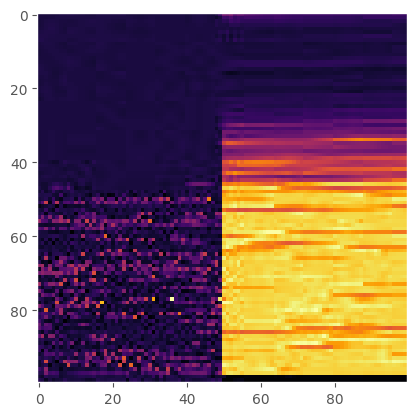

In [38]:
plt.imshow(X_train_2d[0], cmap='inferno')

In [9]:
train_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_train_2d, y_train))
    .shuffle(10)
    .batch(64)
    .prefetch(1)
)

val_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_val_2d, y_val))
    .batch(64)
    .prefetch(1)
)

test_dataset_2d = (
    tf.data.Dataset.from_tensor_slices((X_test_2d, y_test))
    .batch(64)
    .prefetch(1)
)

#### 3.2.2.1. Replicate the architecture in the paper as is

**Question 7:** In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy. Submit the trained final model chosen in task 7, as an .h5-file


**Answer:**

In [40]:
# Since the paper did not include any details regarding padding, and strides, we can
# assume it's same padding for convolutional layers and strides=1 for the max pooling layer.
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_base'
)
model.summary()

Model: "conv2d_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 dropout_1 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 153664)            0         
                                                       

Epoch 1/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 13s - loss: 1.7866 - accuracy: 0.2831 - val_loss: 1.3831 - val_accuracy: 0.2500 - 13s/epoch - 254ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 1.3680 - accuracy: 0.3262 - val_loss: 1.3025 - val_accuracy: 0.3600 - 6s/epoch - 119ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.9550 - accuracy: 0.6966 - val_loss: 0.4368 - val_accuracy: 0.9050 - 6s/epoch - 121ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.3089 - accuracy: 0.8869 - val_loss: 0.2641 - val_accuracy: 0.9050 - 6s/epoch - 121ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.2483 - accuracy: 0.8925 - val_loss: 0.2509 - val_accuracy: 0.9050 - 6s/epoch - 118ms/step
Epoch 6/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.2380 - accuracy: 0.8981 - val_loss: 0.2467 - val_accuracy: 0.9050 - 6s/epoch - 118ms/step
Epoch 7/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.2361 - accuracy: 0.8963 - val_loss: 0.2443 - val_accuracy: 0.9050 - 6s/epoch - 127ms/step
Epoch 8/200
50/50 - 5s - loss: 0.2373 - accuracy: 0.8941 - val_loss: 0.2557 - val_accuracy: 0.9025 - 5s/epoch - 99ms/step
Epoch 9/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.2278 - accuracy: 0.8959 - val_loss: 0.2429 - val_accuracy: 0.9075 - 6s/epoch - 129ms/step
Epoch 10/200
50/50 - 5s - loss: 0.2327 - accuracy: 0.8944 - val_loss: 0.2572 - val_accuracy: 0.9025 - 5s/epoch - 102ms/step
Epoch 11/200
50/50 - 5s - loss: 0.2248 - accuracy: 0.9022 - val_loss: 0.2530 - val_accuracy: 0.9100 - 5s/epoch - 96ms/step
Epoch 12/200
50/50 - 5s - loss: 0.2252 - accuracy: 0.8991 - val_loss: 0.2449 - val_accuracy: 0.9075 - 5s/epoch - 96ms/step
Epoch 13/200


INFO:tensorflow:Assets written to: models\conv2d_base\assets


INFO:tensorflow:Assets written to: models\conv2d_base\assets


50/50 - 6s - loss: 0.2185 - accuracy: 0.8997 - val_loss: 0.2367 - val_accuracy: 0.9050 - 6s/epoch - 120ms/step
Epoch 14/200
50/50 - 5s - loss: 0.2157 - accuracy: 0.9038 - val_loss: 0.2396 - val_accuracy: 0.9050 - 5s/epoch - 96ms/step
Epoch 15/200
50/50 - 5s - loss: 0.2146 - accuracy: 0.8994 - val_loss: 0.2414 - val_accuracy: 0.9100 - 5s/epoch - 96ms/step
Epoch 16/200
50/50 - 5s - loss: 0.2102 - accuracy: 0.9019 - val_loss: 0.2492 - val_accuracy: 0.9075 - 5s/epoch - 98ms/step
Epoch 17/200
50/50 - 5s - loss: 0.2033 - accuracy: 0.9044 - val_loss: 0.2528 - val_accuracy: 0.9050 - 5s/epoch - 98ms/step
Epoch 18/200
50/50 - 5s - loss: 0.2006 - accuracy: 0.9109 - val_loss: 0.2697 - val_accuracy: 0.9000 - 5s/epoch - 97ms/step
Epoch 19/200
50/50 - 5s - loss: 0.2013 - accuracy: 0.9075 - val_loss: 0.2635 - val_accuracy: 0.9025 - 5s/epoch - 97ms/step
Epoch 20/200
50/50 - 5s - loss: 0.1998 - accuracy: 0.9050 - val_loss: 0.2804 - val_accuracy: 0.9025 - 5s/epoch - 101ms/step
Epoch 21/200
50/50 - 5s - l

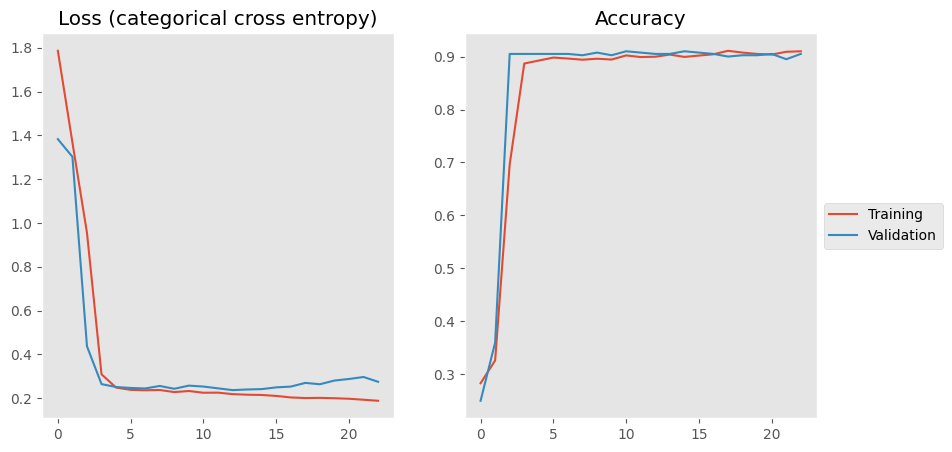

Train performance
50/50 [==============================] - 2s 32ms/step - loss: 0.2015 - accuracy: 0.9044
Val performance
7/7 [==============================] - 0s 30ms/step - loss: 0.2367 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 28ms/step - loss: 0.2697 - accuracy: 0.8900


In [41]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

In [42]:
model.save(model_path / 'model_conv2d.h5')

#### 3.2.2.2. Tuning the replicated CNN

**Question 8:** Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.

**Answer:** In this section, we will consider the following approaches:
1. Using the most complex CNN architecture proposed in the paper
2. Adding more hidden layers to the fully-connected part
3. Tune the configuration of the existing layers of the current network
4. Using transfer learning

##### **Approach 1: Using the most complex CNN architecture proposed in the paper**

In section 5, the authors introduced a slightly more complex CNN architecture with more layers, which yielded the best performance when there are 4 sensors. We will see if the proposed architecture can yields a better accuracy for our task which only has 2 sensors.

In [43]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(128, 3, padding='same'),
        tf.keras.layers.Conv2D(64, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(13, 3, padding='same'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_complex'
)
model.summary()

Model: "conv2d_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     1280      
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      73792     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      18464     
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 13)      3757      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 13)       0         
 2D)                                                             
                                                    

Epoch 1/200


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 - 20s - loss: 1.5744 - accuracy: 0.2625 - val_loss: 1.3895 - val_accuracy: 0.2500 - 20s/epoch - 406ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 - 17s - loss: 1.3296 - accuracy: 0.3522 - val_loss: 1.0559 - val_accuracy: 0.7225 - 17s/epoch - 338ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 - 17s - loss: 0.4949 - accuracy: 0.8338 - val_loss: 0.2826 - val_accuracy: 0.9100 - 17s/epoch - 337ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 - 17s - loss: 0.2763 - accuracy: 0.8822 - val_loss: 0.2527 - val_accuracy: 0.9050 - 17s/epoch - 337ms/step
Epoch 5/200
50/50 - 15s - loss: 0.2542 - accuracy: 0.8847 - val_loss: 0.2884 - val_accuracy: 0.9025 - 15s/epoch - 305ms/step
Epoch 6/200
50/50 - 15s - loss: 0.2462 - accuracy: 0.8950 - val_loss: 0.2556 - val_accuracy: 0.9100 - 15s/epoch - 304ms/step
Epoch 7/200
50/50 - 15s - loss: 0.2360 - accuracy: 0.8922 - val_loss: 0.2672 - val_accuracy: 0.9050 - 15s/epoch - 304ms/step
Epoch 8/200
50/50 - 15s - loss: 0.2365 - accuracy: 0.8988 - val_loss: 0.2570 - val_accuracy: 0.9100 - 15s/epoch - 298ms/step
Epoch 9/200
50/50 - 15s - loss: 0.2285 - accuracy: 0.8997 - val_loss: 0.2533 - val_accuracy: 0.9100 - 15s/epoch - 295ms/step
Epoch 10/200
50/50 - 15s - loss: 0.2274 - accuracy: 0.9000 - val_loss: 0.2588 - val_accuracy: 0.9100 - 15s/epoch - 302ms/step
Epoch 11/200
50/50 - 15s - loss: 0.2284 - accuracy: 0.8941 - val_loss: 0.2535 - val_accuracy: 0.9100 - 15s/epoch - 298ms/step
Epoch 12/2

INFO:tensorflow:Assets written to: models\conv2d_complex\assets


INFO:tensorflow:Assets written to: models\conv2d_complex\assets


50/50 - 17s - loss: 0.2184 - accuracy: 0.9016 - val_loss: 0.2518 - val_accuracy: 0.9025 - 17s/epoch - 336ms/step
Epoch 15/200
50/50 - 14s - loss: 0.2092 - accuracy: 0.9078 - val_loss: 0.2593 - val_accuracy: 0.9000 - 14s/epoch - 289ms/step
Epoch 16/200
50/50 - 15s - loss: 0.2130 - accuracy: 0.9047 - val_loss: 0.2546 - val_accuracy: 0.9025 - 15s/epoch - 291ms/step
Epoch 17/200
50/50 - 15s - loss: 0.1997 - accuracy: 0.9084 - val_loss: 0.2575 - val_accuracy: 0.9075 - 15s/epoch - 291ms/step
Epoch 18/200
50/50 - 15s - loss: 0.1971 - accuracy: 0.9119 - val_loss: 0.2706 - val_accuracy: 0.8875 - 15s/epoch - 292ms/step
Epoch 19/200
50/50 - 15s - loss: 0.1993 - accuracy: 0.9075 - val_loss: 0.2555 - val_accuracy: 0.9050 - 15s/epoch - 292ms/step
Epoch 20/200
50/50 - 15s - loss: 0.1919 - accuracy: 0.9125 - val_loss: 0.2567 - val_accuracy: 0.8975 - 15s/epoch - 291ms/step
Epoch 21/200
50/50 - 15s - loss: 0.1939 - accuracy: 0.9122 - val_loss: 0.3016 - val_accuracy: 0.8975 - 15s/epoch - 295ms/step
Epoch

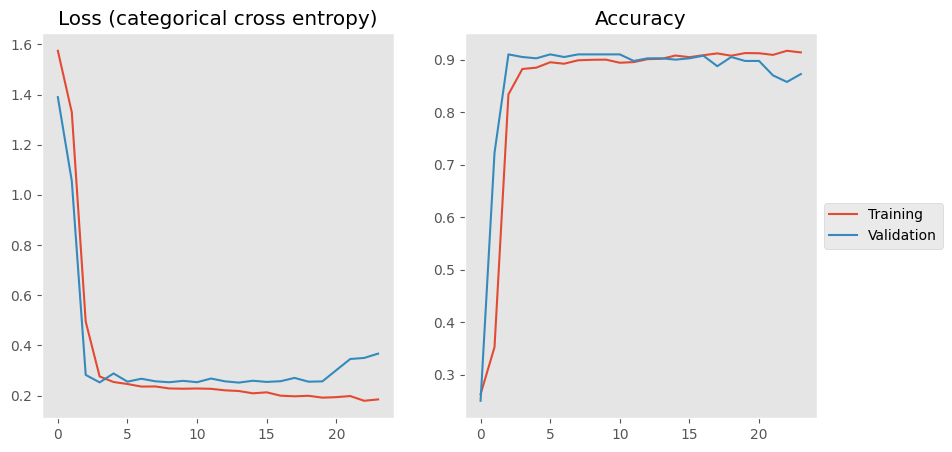

Train performance
50/50 [==============================] - 4s 79ms/step - loss: 0.2127 - accuracy: 0.9000
Val performance
7/7 [==============================] - 1s 81ms/step - loss: 0.2518 - accuracy: 0.9025
Test performance
7/7 [==============================] - 1s 75ms/step - loss: 0.3103 - accuracy: 0.8750


In [44]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

##### **Approach 2: Adding more hidden layers to the fully-connected part**

So far, we have focused on improving the convolutional layers which performed feature extraction, which did not yield better performance. Therefore, it would be reasonable to explore improving the classification layer.

In [11]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(100, 100, 1)),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(3, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax'),
    ],
    name='conv2d_FC'
)
model.summary()

Model: "conv2d_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 153664)            0         
                                                         

Epoch 1/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 45s - loss: 2.5805 - accuracy: 0.3038 - val_loss: 1.3537 - val_accuracy: 0.4850 - 45s/epoch - 898ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 20s - loss: 0.7769 - accuracy: 0.6869 - val_loss: 0.3793 - val_accuracy: 0.9050 - 20s/epoch - 395ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 22s - loss: 0.2649 - accuracy: 0.8913 - val_loss: 0.2615 - val_accuracy: 0.9075 - 22s/epoch - 430ms/step
Epoch 4/200
50/50 - 7s - loss: 0.2479 - accuracy: 0.8978 - val_loss: 0.2676 - val_accuracy: 0.8950 - 7s/epoch - 145ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 19s - loss: 0.2344 - accuracy: 0.8994 - val_loss: 0.2577 - val_accuracy: 0.9000 - 19s/epoch - 377ms/step
Epoch 6/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 20s - loss: 0.2324 - accuracy: 0.8975 - val_loss: 0.2443 - val_accuracy: 0.9050 - 20s/epoch - 399ms/step
Epoch 7/200
50/50 - 7s - loss: 0.2272 - accuracy: 0.8981 - val_loss: 0.2453 - val_accuracy: 0.9025 - 7s/epoch - 145ms/step
Epoch 8/200
50/50 - 7s - loss: 0.2218 - accuracy: 0.9006 - val_loss: 0.2533 - val_accuracy: 0.8900 - 7s/epoch - 145ms/step
Epoch 9/200
50/50 - 7s - loss: 0.2241 - accuracy: 0.9006 - val_loss: 0.2468 - val_accuracy: 0.9050 - 7s/epoch - 143ms/step
Epoch 10/200


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


INFO:tensorflow:Assets written to: models\conv2d_FC\assets


50/50 - 19s - loss: 0.2207 - accuracy: 0.8975 - val_loss: 0.2335 - val_accuracy: 0.9050 - 19s/epoch - 385ms/step
Epoch 11/200
50/50 - 7s - loss: 0.2192 - accuracy: 0.8984 - val_loss: 0.2366 - val_accuracy: 0.9050 - 7s/epoch - 145ms/step
Epoch 12/200
50/50 - 7s - loss: 0.2165 - accuracy: 0.8988 - val_loss: 0.2386 - val_accuracy: 0.9025 - 7s/epoch - 145ms/step
Epoch 13/200
50/50 - 7s - loss: 0.2134 - accuracy: 0.9009 - val_loss: 0.2525 - val_accuracy: 0.8900 - 7s/epoch - 145ms/step
Epoch 14/200
50/50 - 7s - loss: 0.2174 - accuracy: 0.9009 - val_loss: 0.2435 - val_accuracy: 0.9000 - 7s/epoch - 145ms/step
Epoch 15/200
50/50 - 7s - loss: 0.2109 - accuracy: 0.9013 - val_loss: 0.2530 - val_accuracy: 0.8900 - 7s/epoch - 145ms/step
Epoch 16/200
50/50 - 7s - loss: 0.2094 - accuracy: 0.9019 - val_loss: 0.2494 - val_accuracy: 0.8900 - 7s/epoch - 145ms/step
Epoch 17/200
50/50 - 7s - loss: 0.2104 - accuracy: 0.9041 - val_loss: 0.2737 - val_accuracy: 0.8825 - 7s/epoch - 145ms/step
Epoch 18/200
50/50 

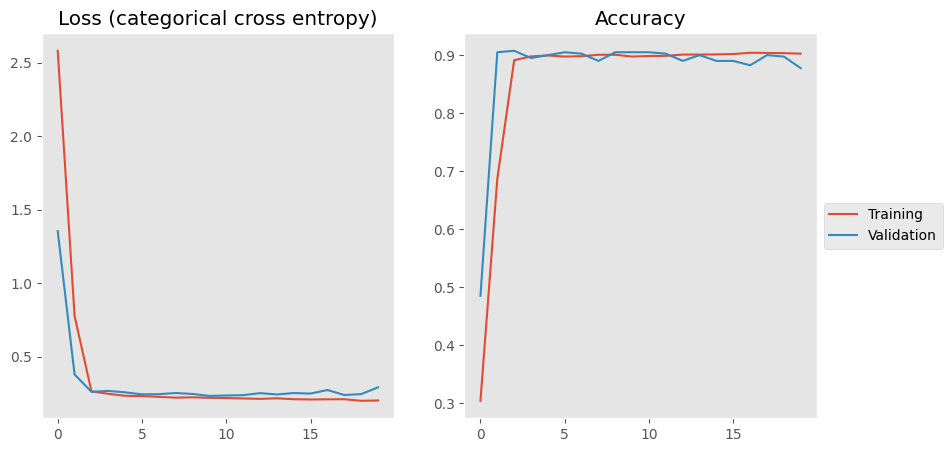

Train performance
50/50 [==============================] - 4s 34ms/step - loss: 0.2139 - accuracy: 0.9019
Val performance
7/7 [==============================] - 0s 32ms/step - loss: 0.2335 - accuracy: 0.9050
Test performance
7/7 [==============================] - 0s 31ms/step - loss: 0.2660 - accuracy: 0.8900


In [14]:
model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

This did not yield better performance.

##### **Approach 3. Tune the configuration of the existing layers of the current network**

In [15]:
class HyperCNN2D(kt.HyperModel):
    def build(self, hp):
        # Parameters
        n_filters_conv1 = hp.Int('n_filters_conv1', min_value=32, max_value=128, step=4)
        n_filters_conv2 = hp.Int('n_filters_conv2', min_value=32, max_value=128, step=4)
        n_filters_conv3 = hp.Int('n_filters_conv3', min_value=16, max_value=64, step=4)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, sampling='linear')
        
        learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.01, sampling='log')

        model = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(100, 100, 1)),
                tf.keras.layers.Conv2D(n_filters_conv1, 3, padding='same'),
                tf.keras.layers.Conv2D(n_filters_conv2, 3, padding='same'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Conv2D(n_filters_conv3, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(3, strides=1),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4, activation='softmax'),
            ],
            name='conv2d_tuned'
        )

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            metrics = ['accuracy']
        )

        return model

tuner = kt.Hyperband(
    HyperCNN2D(),
    objective='val_loss',
    max_epochs=15, # We usually converged around the 10th epoch
    factor=3,
    seed=42,
    directory='./keras_tuning',
    project_name='hypercnn2d',
    overwrite=True,
)

tuner.search(
    train_dataset_2d,
    validation_data=(val_dataset_2d),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]
)

Trial 30 Complete [00h 03m 48s]
val_loss: 1.3862947225570679

Best val_loss So Far: 0.23773032426834106
Total elapsed time: 00h 41m 26s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [16]:
# Extract best hyperparameters
best_hyperparams = tuner.get_best_hyperparameters()[0]

print('-------- Best hyperparameters:')
for hyperparam_name, hyperparam_value in best_hyperparams.values.items():
    print(f'{hyperparam_name}: {hyperparam_value}')

-------- Best hyperparameters:
n_filters_conv1: 36
n_filters_conv2: 124
n_filters_conv3: 44
dropout_rate: 0.30791117675740814
learning_rate: 0.0020674508263974637
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023


Epoch 1/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 21s - loss: 1.9261 - accuracy: 0.3041 - val_loss: 1.2687 - val_accuracy: 0.4225 - 21s/epoch - 429ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 20s - loss: 0.6487 - accuracy: 0.7909 - val_loss: 0.3186 - val_accuracy: 0.9050 - 20s/epoch - 396ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 19s - loss: 0.2730 - accuracy: 0.8913 - val_loss: 0.2542 - val_accuracy: 0.9025 - 19s/epoch - 384ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 19s - loss: 0.2429 - accuracy: 0.8938 - val_loss: 0.2480 - val_accuracy: 0.9050 - 19s/epoch - 374ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 19s - loss: 0.2354 - accuracy: 0.8922 - val_loss: 0.2383 - val_accuracy: 0.9075 - 19s/epoch - 379ms/step
Epoch 6/200
50/50 - 17s - loss: 0.2360 - accuracy: 0.8891 - val_loss: 0.2479 - val_accuracy: 0.9075 - 17s/epoch - 343ms/step
Epoch 7/200


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


INFO:tensorflow:Assets written to: models\conv2d_tuned\assets


50/50 - 19s - loss: 0.2290 - accuracy: 0.8963 - val_loss: 0.2353 - val_accuracy: 0.9050 - 19s/epoch - 381ms/step
Epoch 8/200
50/50 - 17s - loss: 0.2280 - accuracy: 0.8975 - val_loss: 0.2362 - val_accuracy: 0.9075 - 17s/epoch - 342ms/step
Epoch 9/200
50/50 - 17s - loss: 0.2251 - accuracy: 0.8938 - val_loss: 0.2375 - val_accuracy: 0.9050 - 17s/epoch - 347ms/step
Epoch 10/200
50/50 - 17s - loss: 0.2195 - accuracy: 0.8941 - val_loss: 0.2355 - val_accuracy: 0.9050 - 17s/epoch - 344ms/step
Epoch 11/200
50/50 - 17s - loss: 0.2208 - accuracy: 0.8953 - val_loss: 0.2363 - val_accuracy: 0.9075 - 17s/epoch - 343ms/step
Epoch 12/200
50/50 - 17s - loss: 0.2153 - accuracy: 0.8997 - val_loss: 0.2429 - val_accuracy: 0.9050 - 17s/epoch - 342ms/step
Epoch 13/200
50/50 - 17s - loss: 0.2157 - accuracy: 0.8972 - val_loss: 0.2465 - val_accuracy: 0.9025 - 17s/epoch - 344ms/step
Epoch 14/200
50/50 - 17s - loss: 0.2141 - accuracy: 0.9006 - val_loss: 0.2439 - val_accuracy: 0.9025 - 17s/epoch - 344ms/step
Epoch 1

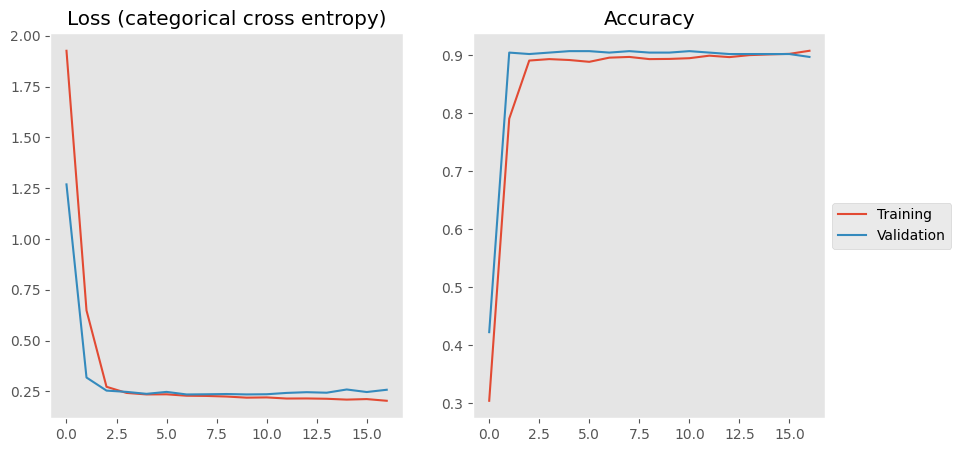

Train performance
50/50 [==============================] - 5s 94ms/step - loss: 0.2182 - accuracy: 0.9028
Val performance
7/7 [==============================] - 1s 83ms/step - loss: 0.2353 - accuracy: 0.9050
Test performance
7/7 [==============================] - 1s 85ms/step - loss: 0.2780 - accuracy: 0.8875


In [17]:
model = tuner.hypermodel.build(best_hyperparams)

model, metrics = train_model(model, train_dataset_2d, val_dataset_2d, test_dataset_2d)
all_metrics.append(metrics)

Same as before, spending additional time in tuning the model did not improve the performance.

##### **Approach 4: Using transfer learning**

We could consider the following options:
- Using pretrained model for the feature extraction layer: This is unlikely to yield better performance, because most image-based models are learned to extract feature from objects in images, which is completely different from the settings we have here (time series data reshaped into images). Therefore, the feature learned by these model are unlikely to be useful.
- Using the architecture of pretrained models: We have seen from the previous experiments that adding more complex structure did not meaningfully improved the model performance. In addition, these complex architecture were tuned for a very large dataset of images, which we do not have. Therefore, our dataset will not be able to fully utilise these architecture.

As a result, using transfer learning is not considered a suitable approach for our task.

# 4. Determining the best model

**Question 9:** Compare the models you have created so far and select the best model (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set. Make sure to record your final test accuracy.


**Answer:**

The following table summarises the model's performances:

In [18]:
pd.DataFrame(all_metrics, columns=['model_name', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'test_loss', 'test_accuracy'])

,model_name,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy
0,recurrent_gru,0.319579,0.869687,0.319394,0.8775,0.342429,0.8500
1,conv1d_base,0.197288,0.902188,0.231081,0.9050,0.256667,0.8900
2,conv1d_regularised,0.220988,0.904063,0.247878,0.9000,0.300314,0.8825
3,conv2d_base,0.201450,0.904375,0.236744,0.9050,0.269749,0.8900
4,conv2d_complex,0.212722,0.900000,0.251839,0.9025,0.310265,0.8750
5,conv2d_FC,0.213935,0.901875,0.233481,0.9050,0.265963,0.8900
6,conv2d_tuned,0.218203,0.902812,0.235303,0.9050,0.278023,0.8875


Unsurprisingly, recurrent models had the lowest performance, and Conv2D-based approach did not offer meaningful improvement over Conv1D-based models. Interestingly, all convolutional-based models achieved a similar level of performance, and adding more layers to the models did not significantly change their performance. In the paper, the authors achieved a 98% accuracy using the Conv2D approach, where we have only achieved 89%, even though the data was processed the same way and the same model architectures were used. This could be because the dataset used in this project is not the same as that used in the paper. Further investigation into data quality may shed light on this.

Nevertheless, we can choose the `conv1d_base` model as our best model for the following reasons:
- It yields the best accuracy and losses, both on the validation and test sets.
- It is the most simple and fastest to train.
- It requires little data preprocessing.
- In terms of model transparency, we can visualise the feature each convolutional filter captures to better understand the data. While this is also possible for the Conv2D-based approach, the vertical dimension does not carry any information (because the adjacent pixels are not correlated).

We can now train the model on the training and validation set, and evaluate on the test set.

In [21]:
train_val_dataset = train_dataset.concatenate(val_dataset)

In [22]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.Conv1D(64, 6, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4, activation='softmax')
    ],
    name='conv1d_base_train_val'
)
model.summary()

Model: "conv1d_base_train_val"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4995, 64)          832       
                                                                 
 flatten_2 (Flatten)         (None, 319680)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1278724   
                                                                 
Total params: 1,279,556
Trainable params: 1,279,556
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 4s - loss: 1.9654 - accuracy: 0.5561 - val_loss: 0.5797 - val_accuracy: 0.7700 - 4s/epoch - 69ms/step
Epoch 2/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.3606 - accuracy: 0.8850 - val_loss: 0.2964 - val_accuracy: 0.8900 - 3s/epoch - 52ms/step
Epoch 3/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2768 - accuracy: 0.8892 - val_loss: 0.2788 - val_accuracy: 0.8825 - 3s/epoch - 54ms/step
Epoch 4/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2531 - accuracy: 0.8889 - val_loss: 0.2664 - val_accuracy: 0.8900 - 3s/epoch - 53ms/step
Epoch 5/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2448 - accuracy: 0.8864 - val_loss: 0.2533 - val_accuracy: 0.8900 - 3s/epoch - 51ms/step
Epoch 6/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2336 - accuracy: 0.8953 - val_loss: 0.2512 - val_accuracy: 0.8900 - 3s/epoch - 50ms/step
Epoch 7/200
57/57 - 2s - loss: 0.2324 - accuracy: 0.8922 - val_loss: 0.2530 - val_accuracy: 0.8825 - 2s/epoch - 35ms/step
Epoch 8/200
57/57 - 2s - loss: 0.2235 - accuracy: 0.8986 - val_loss: 0.2553 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 9/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2263 - accuracy: 0.8944 - val_loss: 0.2497 - val_accuracy: 0.8875 - 3s/epoch - 51ms/step
Epoch 10/200
57/57 - 2s - loss: 0.2219 - accuracy: 0.8986 - val_loss: 0.2546 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 11/200
57/57 - 2s - loss: 0.2192 - accuracy: 0.8975 - val_loss: 0.2538 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 12/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2189 - accuracy: 0.8964 - val_loss: 0.2477 - val_accuracy: 0.8900 - 3s/epoch - 55ms/step
Epoch 13/200
57/57 - 2s - loss: 0.2141 - accuracy: 0.9003 - val_loss: 0.2480 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 14/200
57/57 - 2s - loss: 0.2113 - accuracy: 0.9028 - val_loss: 0.2510 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 15/200
57/57 - 2s - loss: 0.2097 - accuracy: 0.9039 - val_loss: 0.2489 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 16/200
57/57 - 2s - loss: 0.2049 - accuracy: 0.9003 - val_loss: 0.2493 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 17/200
57/57 - 2s - loss: 0.2214 - accuracy: 0.8975 - val_loss: 0.2532 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 18/200
57/57 - 2s - loss: 0.2110 - accuracy: 0.9006 - val_loss: 0.2546 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 19/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 3s - loss: 0.2025 - accuracy: 0.9025 - val_loss: 0.2471 - val_accuracy: 0.8900 - 3s/epoch - 52ms/step
Epoch 20/200


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


INFO:tensorflow:Assets written to: models\conv1d_base_train_val\assets


57/57 - 4s - loss: 0.1975 - accuracy: 0.9058 - val_loss: 0.2445 - val_accuracy: 0.8900 - 4s/epoch - 64ms/step
Epoch 21/200
57/57 - 2s - loss: 0.1897 - accuracy: 0.9083 - val_loss: 0.2468 - val_accuracy: 0.8900 - 2s/epoch - 34ms/step
Epoch 22/200
57/57 - 2s - loss: 0.1904 - accuracy: 0.9097 - val_loss: 0.2465 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 23/200
57/57 - 2s - loss: 0.1832 - accuracy: 0.9097 - val_loss: 0.2506 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 24/200
57/57 - 2s - loss: 0.1834 - accuracy: 0.9111 - val_loss: 0.2480 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 25/200
57/57 - 2s - loss: 0.1778 - accuracy: 0.9158 - val_loss: 0.2476 - val_accuracy: 0.8900 - 2s/epoch - 35ms/step
Epoch 26/200
57/57 - 2s - loss: 0.1735 - accuracy: 0.9203 - val_loss: 0.2504 - val_accuracy: 0.8850 - 2s/epoch - 35ms/step
Epoch 27/200
57/57 - 2s - loss: 0.1681 - accuracy: 0.9208 - val_loss: 0.2484 - val_accuracy: 0.8825 - 2s/epoch - 35ms/step
Epoch 28/200
57/57 - 2s - los

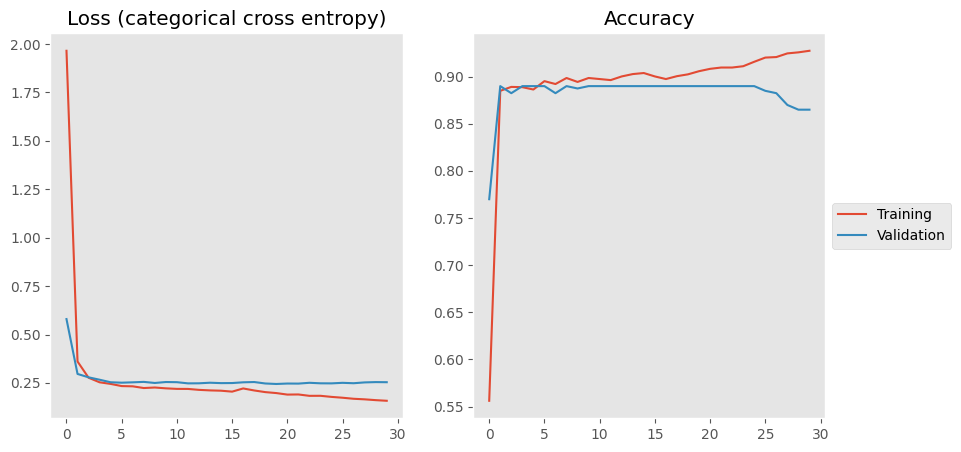

Train performance
57/57 [==============================] - 1s 19ms/step - loss: 0.1794 - accuracy: 0.9133
Val performance
7/7 [==============================] - 0s 17ms/step - loss: 0.2445 - accuracy: 0.8900
Test performance
7/7 [==============================] - 0s 17ms/step - loss: 0.2445 - accuracy: 0.8900


In [23]:
model, metrics = train_model(model, train_val_dataset, test_dataset, test_dataset)

In [24]:
pd.DataFrame([metrics], columns=['model_name', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy', 'test_loss', 'test_accuracy'])

,model_name,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy
0,conv1d_base_train_val,0.179389,0.913333,0.244501,0.89,0.244501,0.89
